In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state
import sklearn
from sklearn.metrics import roc_auc_score
import random

random.seed(0)
import numpy as np
np.random.seed(123)
import lime
import lime.lime_tabular

In [2]:
def getMNIST():
    t0 = time.time()
    train_samples = 60000
    # Load data from https://www.openml.org/d/554
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    X = X.reshape((X.shape[0], -1))
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)
    scaler = StandardScaler()
    #scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print("==================")
    X_train=list(X_train)
    X_test=list(X_test)
    print(len(X_train))
    print(len(X_test))
    print("==================")
    
    return X_train, y_train, X_test, y_test

In [21]:
def make_38_Subset(X_train, y_train, X_test, y_test):
    templist = []
    for tup in zip(X_train, y_train):
        if(tup[1]=='8' or tup[1]=='3'):
            templist.append(list(tup))

    testList = []
    for tup in zip(X_test, y_test):
        if(tup[1]=='8' or tup[1]=='3'):
            testList.append(list(tup))

    print("3/8 Training set size = "+str(len(templist)))
    print("3/8 Test set size = "+str(len(testList)))
    
    X_test=[]
    y_test=[]

    for tup in testList:
        X_test.append(tup[0])
        y_test.append(tup[1])


    #seed_size=int(0.1*len(templist))
    seed_size = 100
    seed_list=templist[0:seed_size]
    print("Initial Seed set size = "+str(len(seed_list)))
 
    unlabelled_list=templist[seed_size:500]
    print("Unlabelled dataset size = "+str(len(unlabelled_list)))
    
    return seed_list, unlabelled_list, X_test, y_test

In [4]:
def select_based_on_explanation_from_unlabeled(seed_list, unlabelled_list, batch_size, clf):
    print(len(seed_list))
    print(len(unlabelled_list))
    ulabelled_X=[]
    ulabelled_y=[]
    
    for tup in unlabelled_list:
        ulabelled_X.append(list(tup[0]))
        ulabelled_y.append(list(tup[1]))
       
    feature_names=[]

    for i in range(784):
        feature='feature_'+str(i)
        feature_names.append(feature)
    

    class_names=[]
    classes=['3','8']

    for i in classes:
        class_1='class_'+str(i)
        class_names.append(class_1)
    
    
    seed_X=[]
    seed_y=[]

    for tup in seed_list:
        seed_X.append(list(tup[0]))
        seed_y.append(list(tup[1]))
        
        
    explainer = lime.lime_tabular.LimeTabularExplainer(np.array(seed_X), feature_names=feature_names, class_names=class_names, discretize_continuous=False)
    
    
    total_np_array=[]
    for item in seed_list:
        #print(item)
        exp = explainer.explain_instance(item[0], clf.predict_proba, num_features=784)
        #print(exp.as_list())
        vectors = np.empty([1, 784])
        for elem in list(exp.as_list()):
            np.append(vectors, elem[1], axis=None)
        total_np_array.append(vectors[0])
        
    
    seed_mean = np.mean(np.array(total_np_array), axis=0)
    #print(seed_mean)
    
    explainer = lime.lime_tabular.LimeTabularExplainer(np.array(ulabelled_X), feature_names=feature_names, class_names=class_names, discretize_continuous=False)
    
    del_s = [] # new points to add to s
    
    sums=[]
    for item in unlabelled_list:
        #print(item[0])
        exp = explainer.explain_instance(np.array(item[0]), clf.predict_proba, num_features=784)
        #print(exp.as_list)
        vectors = np.empty([1, 784])
        for elem in list(exp.as_list()):
            np.append(vectors, elem[1], axis=None)
        np_vector=vectors[0]
        sums.append(np.sum(np.subtract(seed_mean, np_vector)))
    
    #print("Sum length="+str(len(sums)))
    for i in range(batch_size):
        max_index=sums.index(max(sums))
        del_s.append(unlabelled_list[max_index])
        del unlabelled_list[max_index]
        del sums[max_index]
    
    #print("Sum length="+str(len(sums)))
    #print(len(unlabelled_list))
    
    return del_s, unlabelled_list

In [5]:
import matplotlib.pyplot as plt

def select_based_on_explanation_from_unlabeled_based_on_seed_set_split(seed_list, unlabelled_list, batch_size, clf):
    ulabelled_X=[]
    ulabelled_y=[]
    
    for tup in unlabelled_list:
        ulabelled_X.append(list(tup[0]))
        ulabelled_y.append(list(tup[1]))
       
    feature_names=[]

    for i in range(784):
        feature='feature_'+str(i)
        feature_names.append(feature)
    

    class_names=[]
    classes=['3','8']

    for i in classes:
        class_1='class_'+str(i)
        class_names.append(class_1)
    
    
    seed_X=[]
    seed_y=[]

    for tup in seed_list:
        seed_X.append(list(tup[0]))
        seed_y.append(list(tup[1]))
        
        
    explainer = lime.lime_tabular.LimeTabularExplainer(np.array(seed_X), feature_names=feature_names, class_names=class_names, discretize_continuous=False)
    
    
    total_np_array=[]
    for item in seed_list:
        #print(item)
        exp = explainer.explain_instance(np.array(item[0]), clf.predict_proba, num_features=784)
        #print(exp.as_list())
        vectors = np.empty([1, 784])
        for elem in list(exp.as_list()):
            np.append(vectors, elem[1], axis=None)
        total_np_array.append(vectors[0])
        
    
    seed_mean = np.mean(np.array(total_np_array), axis=0)
    #print(seed_mean)
    
    
    
    ulabelled_X=[]
    ulabelled_y=[]

    for tup in unlabelled_list:
        ulabelled_X.append(list(tup[0]))
        ulabelled_y.append(list(tup[1]))
        
    import random
    random_batch=[]
    for i in range(batch_size):
        elem=random.choice(unlabelled_list)
        random_batch.append(elem)
        
    #print(random_batch[1][1])
    
    new_x0=[]
    new_y0=[]
    
    for tup in random_batch:
        new_x0.append(list(tup[0]))
        new_y0.append(list('3'))
    
    #print(new_y0)
    
    new_x1=[]
    new_y1=[]
    
    for tup in random_batch:
        new_x1.append(list(tup[0]))
        new_y1.append(list('8'))
    
    #print(new_y0[0], new_y1[0])
    
    ## Preparing Seed X0
    
    seed_x0=[]
    seed_y0=[]
    
    for tup in seed_list:
        seed_x0.append(list(tup[0]))
        seed_y0.append(list(tup[1]))
    
    #print(seed_y0[-1])
    
    
    for x in new_x0:
        seed_x0.append(x)
        
    for y in new_y0:
        seed_y0.append(y)
        
    #print(seed_y0)
    
    
    ## Preparing Seed X1
    
    seed_x1=[]
    seed_y1=[]
    
    for tup in seed_list:
        seed_x1.append(list(tup[0]))
        seed_y1.append(list(tup[1]))
    
    for x in new_x1:
        seed_x1.append(x)
        
    for y in new_y1:
        seed_y1.append(y)
        
        
        
    #print(seed_y1)
    
    clf0 = LogisticRegression(C=50. / 60000, penalty='l1', solver='saga', tol=0.1)
    clf0.fit(seed_x0, seed_y0)
    
    clf1 = LogisticRegression(C=50. / 60000, penalty='l1', solver='saga', tol=0.1)
    clf1.fit(seed_x1, seed_y1)
    
    explainer0 = lime.lime_tabular.LimeTabularExplainer(np.array(seed_x0), feature_names=feature_names, class_names=class_names, discretize_continuous=False)
    explainer1 = lime.lime_tabular.LimeTabularExplainer(np.array(seed_x1), feature_names=feature_names, class_names=class_names, discretize_continuous=False)
    
    # Mean for LIME(M(S0),x)
    
    total_np_array_0=[]
    num_features=784
    for item in seed_x0:
        exp = explainer0.explain_instance(np.array(item), clf.predict_proba, num_features=num_features)
        vectors = np.empty([1, num_features])
        for elem in list(exp.as_list()):
            np.append(vectors, elem[1], axis=None)
        total_np_array_0.append(vectors[0])
        
    
    seed_mean0 = np.mean(np.array(total_np_array_0), axis=0)
    
    
    # Mean for LIME(M(S1),x)
    
    total_np_array_1=[]
    num_features=784
    for item in seed_x1:
        exp = explainer0.explain_instance(np.array(item), clf.predict_proba, num_features=num_features)
        vectors = np.empty([1, num_features])
        for elem in list(exp.as_list()):
            np.append(vectors, elem[1], axis=None)
        total_np_array_1.append(vectors[0])
        
    
    seed_mean1 = np.mean(np.array(total_np_array_1), axis=0)
    
    # Computing the maximum of del[LIME(M(S0),x)] and del[LIME(M(S1),x)]
    
    delMO = np.subtract(np.array(seed_mean0), np.array(seed_mean))
    delM1 = np.subtract(np.array(seed_mean1), np.array(seed_mean))
    
    
    if(np.mean(delMO) > np.mean(delM1)):
        final_seed_x=seed_x0
        final_seed_y=seed_y0
    else:
        final_seed_x=seed_x1
        final_seed_y=seed_y1
        
    #print(unlabelled_list.index(final_seed_x))
    final_seed=[]
    
    
    print(len(ulabelled_X))
    for elem in zip(final_seed_x, final_seed_y):
        final_seed.append(elem)
        
        i=0
        index=[]
        
        for index, item in enumerate(ulabelled_X):
            if(item==elem[0]):
                print("Found at index"+str(index))
                del ulabelled_X[index]
                del ulabelled_y[index]
                
    
    print(len(ulabelled_X))
    
    new_unlabelled_list = []
    for elem in zip(ulabelled_X, ulabelled_y):
        new_unlabelled_list.append(elem)
        
    return final_seed, new_unlabelled_list

In [6]:
def select_based_on_uncertainity_from_unlabeled(unlabelled_list, batch_size, clf):
    ulabelled_X=[]
    ulabelled_y=[]
    
    for tup in unlabelled_list:
        ulabelled_X.append(list(tup[0]))
        ulabelled_y.append(list(tup[1]))
        
    modified_u = [] # modified unlabeled
    del_s = [] # new points to add to s
    
    for i in range(batch_size):
        predictions_label_wise=np.array(clf.predict_proba(ulabelled_X))
        uncertainity_list = list(1-predictions_label_wise.max(axis=1))
        max_index = uncertainity_list.index(max(uncertainity_list))
        del unlabelled_list[max_index]
        modified_u = unlabelled_list
        del_s.append(unlabelled_list[max_index])
    
    print(len(del_s))
    print(len(modified_u))
    return del_s, modified_u

In [7]:
def train_model(data, X_test, y_test):
    print("--------------------Start------------------")
    train_samples = 60000
    clf = LogisticRegression(C=50. / train_samples, penalty='l2', solver='saga', tol=0.1)
    print("Training with seed size: " + str(len(data)))
    #random.shuffle(data)
    X_train=[]
    y_train=[]
    for i in range(len(data)):
        try:
            #print(data[i][1])
            X_train.append(list(data[i][0]))
            y_train.append(data[i][1])
        except:
            pass
        
    clf.fit(X_train, y_train)
    accuracy = sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))
    print("Accuracy on the Test Set is : "+str(sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))))
    print("--------------------End------------------")
    return clf, accuracy

In [8]:
print ("Making MNIST data...")
X_train, y_train, X_test, y_test = getMNIST()

Making MNIST data...
60000
10000


In [23]:
print ("Getting MNIST 3/8 classification data...")
s, u, X_test, y_test = make_38_Subset(X_train, y_train, X_test, y_test)

batch_size = 50
niters = 5

explanation_accuracies_2 = []
seed_set_size = []

for i in range(niters):
    print("|S|_{} = {}, |U|_{} = {}".format(i, len(s), i, len(u)))
    clf, accuracy = train_model(s, X_test, y_test)
    explanation_accuracies_2.append(accuracy)
    seed_set_size.append(len(s))

    s, u = select_based_on_explanation_from_unlabeled_based_on_seed_set_split(s, u, batch_size, clf)

Getting MNIST 3/8 classification data...
3/8 Training set size = 11949
3/8 Test set size = 2017
Initial Seed set size = 100
Unlabelled dataset size = 400
|S|_0 = 100, |U|_0 = 400
--------------------Start------------------
Training with seed size: 100
Accuracy on the Test Set is : 0.880019831432821
--------------------End------------------


/home/ishani/anaconda3/envs/fair/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ishani/anaconda3/envs/fair/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


400
Found at index244
Found at index183
Found at index296
Found at index111
Found at index255
Found at index71
Found at index142
Found at index379
Found at index48
Found at index308
Found at index125
Found at index264
Found at index350
Found at index298
Found at index73
Found at index152
Found at index49
Found at index357
Found at index37
Found at index334
Found at index160
Found at index230
Found at index271
Found at index48
Found at index170
Found at index209
Found at index151
Found at index290
Found at index303
Found at index98
Found at index262
Found at index210
Found at index246
Found at index124
Found at index31
Found at index256
Found at index7
Found at index44
Found at index332
Found at index185
Found at index326
Found at index307
Found at index286
Found at index0
Found at index279
Found at index227
Found at index152
Found at index112
352
|S|_1 = 150, |U|_1 = 352
--------------------Start------------------
Training with seed size: 150


/home/ishani/anaconda3/envs/fair/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy on the Test Set is : 0.8606841844323252
--------------------End------------------


/home/ishani/anaconda3/envs/fair/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ishani/anaconda3/envs/fair/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


352
Found at index166
Found at index32
Found at index96
Found at index287
Found at index111
Found at index119
Found at index71
Found at index272
Found at index223
Found at index45
Found at index40
Found at index156
Found at index250
Found at index240
Found at index52
Found at index146
Found at index267
Found at index141
Found at index59
Found at index263
Found at index157
Found at index259
Found at index97
Found at index285
Found at index277
Found at index137
Found at index211
Found at index279
Found at index181
Found at index149
Found at index267
Found at index113
Found at index136
Found at index88
Found at index89
Found at index88
Found at index16
Found at index276
Found at index298
Found at index118
Found at index216
Found at index33
Found at index41
Found at index304
Found at index58
Found at index66
Found at index18
305
|S|_2 = 200, |U|_2 = 305
--------------------Start------------------
Training with seed size: 200
Accuracy on the Test Set is : 0.7040158651462568
----------------

/home/ishani/anaconda3/envs/fair/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ishani/anaconda3/envs/fair/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ishani/anaconda3/envs/fair/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


305
Found at index276
Found at index200
Found at index267
Found at index141
Found at index265
Found at index120
Found at index110
Found at index294
Found at index210
Found at index288
Found at index138
Found at index224
Found at index245
Found at index178
Found at index42
Found at index161
Found at index58
Found at index238
Found at index283
Found at index164
Found at index95
Found at index119
Found at index8
Found at index131
Found at index107
Found at index176
Found at index84
Found at index157
Found at index199
Found at index30
Found at index48
Found at index69
Found at index22
Found at index263
Found at index244
Found at index34
Found at index12
Found at index55
Found at index85
Found at index258
Found at index53
Found at index40
Found at index163
Found at index16
Found at index10
Found at index82
259
|S|_3 = 250, |U|_3 = 259
--------------------Start------------------
Training with seed size: 250


/home/ishani/anaconda3/envs/fair/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy on the Test Set is : 0.90233019335647
--------------------End------------------


/home/ishani/anaconda3/envs/fair/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ishani/anaconda3/envs/fair/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


259
Found at index94
Found at index63
Found at index243
Found at index105
Found at index31
Found at index11
Found at index212
Found at index49
Found at index127
Found at index33
Found at index106
Found at index33
Found at index144
Found at index168
Found at index210
Found at index86
Found at index241
Found at index224
Found at index19
Found at index186
Found at index93
Found at index168
Found at index220
Found at index79
Found at index93
Found at index27
Found at index73
Found at index73
Found at index156
Found at index111
Found at index53
Found at index199
Found at index77
Found at index6
Found at index209
Found at index182
Found at index136
Found at index156
Found at index170
Found at index68
Found at index199
Found at index33
Found at index145
Found at index20
Found at index118
214
|S|_4 = 300, |U|_4 = 214
--------------------Start------------------
Training with seed size: 300
Accuracy on the Test Set is : 0.7744174516608825
--------------------End------------------


/home/ishani/anaconda3/envs/fair/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ishani/anaconda3/envs/fair/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ishani/anaconda3/envs/fair/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


214
Found at index34
Found at index60
Found at index193
Found at index121
Found at index88
Found at index152
Found at index71
Found at index166
Found at index87
Found at index145
Found at index154
Found at index150
Found at index33
Found at index171
Found at index75
Found at index92
Found at index176
Found at index98
Found at index194
Found at index152
Found at index20
Found at index0
Found at index139
Found at index45
Found at index158
Found at index77
Found at index36
Found at index51
Found at index142
Found at index99
Found at index83
Found at index154
Found at index127
Found at index7
Found at index86
Found at index149
Found at index89
Found at index161
Found at index140
Found at index9
Found at index35
Found at index13
Found at index54
171


In [25]:
print ("Getting MNIST 3/8 classification data...")
s, u, X_test, y_test = make_38_Subset(X_train, y_train, X_test, y_test)

batch_size = 50
niters = 5

explanation_accuracies = []
seed_set_size = []

for i in range(niters):
    print("|S|_{} = {}, |U|_{} = {}".format(i, len(s), i, len(u)))
    clf, accuracy = train_model(s, X_test, y_test)
    explanation_accuracies.append(accuracy)
    seed_set_size.append(len(s))

    del_s, u = select_based_on_explanation_from_unlabeled(s, u, batch_size, clf)
    s = s + del_s
    

Getting MNIST 3/8 classification data...
3/8 Training set size = 11949
3/8 Test set size = 2017
Initial Seed set size = 100
Unlabelled dataset size = 400
|S|_0 = 100, |U|_0 = 400
--------------------Start------------------
Training with seed size: 100
Accuracy on the Test Set is : 0.8815071888943976
--------------------End------------------
100
400
|S|_1 = 150, |U|_1 = 350
--------------------Start------------------
Training with seed size: 150
Accuracy on the Test Set is : 0.856717897868121
--------------------End------------------
150
350
|S|_2 = 200, |U|_2 = 300
--------------------Start------------------
Training with seed size: 200
Accuracy on the Test Set is : 0.8820029747149232
--------------------End------------------
200
300
|S|_3 = 250, |U|_3 = 250
--------------------Start------------------
Training with seed size: 250
Accuracy on the Test Set is : 0.8889439762022806
--------------------End------------------
250
250
|S|_4 = 300, |U|_4 = 200
--------------------Start---------

KeyboardInterrupt: 

In [38]:
print ("Getting MNIST 3/8 classification data...")
s, u, X_test, y_test = make_38_Subset(X_train, y_train, X_test, y_test)

batch_size = 50
#stopping_criteria = int(len(unlabelled_list)/100)
#print(len(X_test))

niters = 5

max_uncertainity_accuracies = []
seed_set_size = []

for i in range(niters):
    
    print("|S|_{} = {}, |U|_{} = {}".format(i, len(s), i, len(u)))
    clf, accuracy = train_model(s, X_test, y_test)
    max_uncertainity_accuracies.append(accuracy)
    seed_set_size.append(len(s))
    
    del_s, u = select_based_on_uncertainity_from_unlabeled(u, batch_size, clf)
    s = s + del_s

Getting MNIST 3/8 classification data...
3/8 Training set size = 11949
3/8 Test set size = 2017
Initial Seed set size = 100
Unlabelled dataset size = 400
|S|_0 = 100, |U|_0 = 400
--------------------Start------------------
Training with seed size: 100
Accuracy on the Test Set is : 0.8829945463559742
--------------------End------------------
50
350
|S|_1 = 150, |U|_1 = 350
--------------------Start------------------
Training with seed size: 150
Accuracy on the Test Set is : 0.8715914724838869
--------------------End------------------
50
300
|S|_2 = 200, |U|_2 = 300
--------------------Start------------------
Training with seed size: 200
Accuracy on the Test Set is : 0.8750619732275657
--------------------End------------------
50
250
|S|_3 = 250, |U|_3 = 250
--------------------Start------------------
Training with seed size: 250
Accuracy on the Test Set is : 0.8859692612791275
--------------------End------------------
50
200
|S|_4 = 300, |U|_4 = 200
--------------------Start------------

In [28]:
seed_set_size, max_uncertainity_accuracies, explanation_accuracies

([100, 150],
 [0.8805156172533466, 0.8760535448686168],
 [0.8815071888943976,
  0.856717897868121,
  0.8820029747149232,
  0.8889439762022806,
  0.8909271194843827])

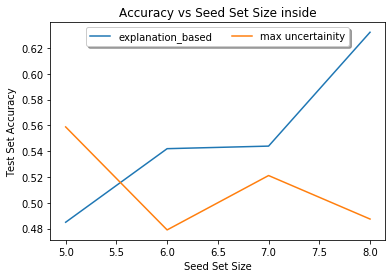

In [14]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(seed_set_size, explanation_accuracies[0:4], label='explanation_based')
ax.plot(seed_set_size, max_uncertainity_accuracies[0:4], label='max uncertainity')
plt.title('Legend inside')
ax.legend(loc='upper center', shadow=True, ncol=2)
plt.xlabel('Seed Set Size')
plt.ylabel('Test Set Accuracy')
plt.title('Accuracy vs Seed Set Size inside')
plt.show()
plt.show()

In [29]:
import numpy as np
import numpy.random as npr

def select_random_from_unlabeled(u, batch_size):
    selected = set(npr.choice(len(u), batch_size, replace=False)) #these will no longer be unlabeled
    
    modified_u = [] # modified unlabeled
    del_s = [] # new points to add to s
    
    i=0
    for x in u:
        if i in selected:
            del_s.append(x)
        else:
            modified_u.append(x)
            
        i=i+1
    return del_s, modified_u

In [40]:
print ("Getting MNIST 3/8 classification data...")
s, u, X_test, y_test = make_38_Subset(X_train, y_train, X_test, y_test)

batch_size = 50
#stopping_criteria = int(len(unlabelled_list)/100)
#print(len(X_test))

niters = 5

random_accuracies = []
seed_set_size=[]

for i in range(niters):
    
    print("|S|_{} = {}, |U|_{} = {}".format(i, len(s), i, len(u)))
    clf, accuracy = train_model(s, X_test, y_test)
    random_accuracies.append(accuracy)
    seed_set_size.append(len(s))    
    
    del_s, u = select_random_from_unlabeled(u, batch_size)
    s = s + del_s
    

Getting MNIST 3/8 classification data...
3/8 Training set size = 11949
3/8 Test set size = 2017
Initial Seed set size = 100
Unlabelled dataset size = 400
|S|_0 = 100, |U|_0 = 400
--------------------Start------------------
Training with seed size: 100
Accuracy on the Test Set is : 0.881011403073872
--------------------End------------------
|S|_1 = 150, |U|_1 = 350
--------------------Start------------------
Training with seed size: 150
Accuracy on the Test Set is : 0.9048091224590976
--------------------End------------------
|S|_2 = 200, |U|_2 = 300
--------------------Start------------------
Training with seed size: 200
Accuracy on the Test Set is : 0.9191869112543382
--------------------End------------------
|S|_3 = 250, |U|_3 = 250
--------------------Start------------------
Training with seed size: 250
Accuracy on the Test Set is : 0.9003470500743679
--------------------End------------------
|S|_4 = 300, |U|_4 = 200
--------------------Start------------------
Training with seed siz

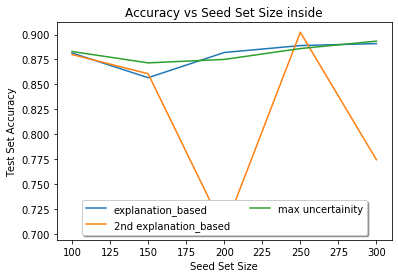

In [41]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
#ax.plot(seed_set_size, random_accuracies, label='random')
ax.plot(seed_set_size, explanation_accuracies, label='explanation_based')
ax.plot(seed_set_size, explanation_accuracies_2, label='2nd explanation_based')
ax.plot(seed_set_size, max_uncertainity_accuracies, label='max uncertainity')
plt.title('Legend inside')
ax.legend(loc='lower center', shadow=True, ncol=2)
plt.xlabel('Seed Set Size')
plt.ylabel('Test Set Accuracy')
plt.title('Accuracy vs Seed Set Size inside')
plt.show()
plt.show()